In [36]:
import sys
utils = "/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src"
if utils not in sys.path:
    sys.path.append(utils)


from utils.file_utils import add_project_dirs_to_path

# Add project root and src directory to Python path
add_project_dirs_to_path()

# Standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Import from project modules
# from pi_vae.pi_vae import *
# from pi_vae.util import *
from modeling.vae_model import *
from utils.data_processing import *
from utils.plotting import *

# Import Keras callback
from keras.callbacks import ModelCheckpoint

# Import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
import seaborn

# Suppress warnings
warnings.filterwarnings("ignore")

# Autoreload modules
%load_ext autoreload
%autoreload 2

# Show plots inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

- This notebook will focus primarily on the visual cortex, because there is a stronger signal to noise ratio for purely visual behavior variables.
- Additionally, I have been spooked to look at each brain region independently
- Also go spooked that there are outliers in the kinematics information (Velocity, position, total distance)

In [7]:
VERSION = 1
LATENT_DIM = 6
RANDOM_SEED = 999
BRAIN_REGIONS = ['CA1', 'VISp']
MODEL_TYPES = ['vae', 'pivae']

SAVE_PLOTS = True

### Extract data

In [8]:
ecephys_session_id = 766640955
brain_region = BRAIN_REGIONS[0]

spike_count_pivot, behavior_data_df = extract_data(ecephys_session_id, brain_region)

## Workflows

### Pi-VAE - X_h, F

#### Transform Data

In [9]:
selected_behavior_vars = ['frame']

x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, selected_behavior_vars)

#### Load Data

In [10]:
x_train, u_train, x_valid, u_valid, x_test, u_test = load_data(x_all=x_all, u_all=u_all)

In [11]:
model_chk_path, workflow_name = get_model_paths(brain_region=brain_region,
                                    selected_behavior_vars=selected_behavior_vars, 
                                    latent_dim=LATENT_DIM, 
                                    random_seed=RANDOM_SEED, 
                                    model_type=MODEL_TYPES[1]);

In [12]:
# Initialize model
vae = initialize_model(dim_x=x_all[0].shape[-1], 
                       dim_z=LATENT_DIM,
                       dim_u=u_all[0].shape[-1], 
                       gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4, random_seed=RANDOM_SEED)

# Train model
s_n = train_model(vae, x_train, u_train, x_valid, u_valid, model_chk_path)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 134)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 6),                  24964     ['input_1[0][0]',             
                              (None, 6),                             'input_3[0][0]']             
                              (None, 6),                                                          
                              (None, 6),                                                        

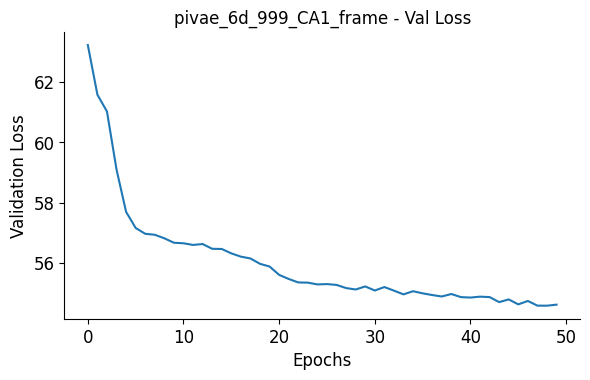

In [13]:
plot_validation_loss(s_n, workflow_name, VERSION, save_plot=False, show_plot=True)

In [14]:
outputs = inference(vae, x_all, u_all, model_chk_path) # post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var

##### TODO: clean/Package this variance compute and sort code

In [15]:
# Calculate variances of all columns of outputs[0]
variances = outputs[0].var(axis=0)

# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]

print(sorted_outputs.var(axis=0))

[2.0468259e+00 1.9803522e+00 6.3194553e-03 2.1225356e-03 3.2833117e-04
 9.5218405e-05]


#### Plotting

Latent 1 idx: 3
Latent 2 idx: 1


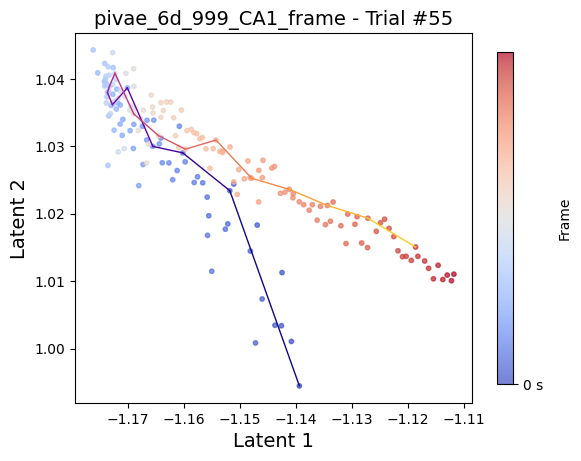

In [16]:
plot_single_latent_trajectory(outputs, sorted_indices, workflow_name, save_plot=False, save_dir=None, show_plot=True)

Latent 1 idx: 3
Latent 2 idx: 1


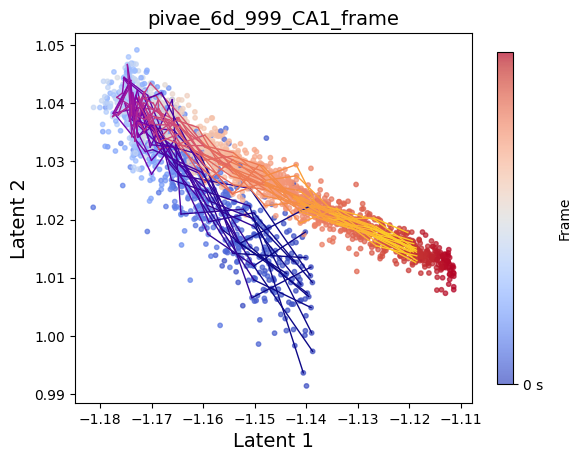

In [17]:
plot_dir = get_plot_dir(workflow_name, version_number=VERSION, plot_type='latent')

plot_multi_latent_trajectory(outputs, sorted_indices, workflow_name, num_stims=15, save_plot=SAVE_PLOTS, save_dir=plot_dir, show_plot=True)

### Pi-VAE - X_h, position

#### Transform Data

In [18]:
selected_behavior_vars = ['position']

x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, selected_behavior_vars)

#### Load Data

In [19]:
x_train, u_train, x_valid, u_valid, x_test, u_test = load_data(x_all=x_all, u_all=u_all)

In [20]:
model_chk_path, workflow_name = get_model_paths(brain_region=brain_region,
                                    selected_behavior_vars=selected_behavior_vars, 
                                    latent_dim=LATENT_DIM, 
                                    random_seed=RANDOM_SEED, 
                                    model_type=MODEL_TYPES[1]);

print(f"Workflow Name: {workflow_name}")

Workflow Name: pivae_6d_999_CA1_position


In [21]:
# Initialize model
vae = initialize_model(dim_x=x_all[0].shape[-1], 
                       dim_z=LATENT_DIM,
                       dim_u=u_all[0].shape[-1], 
                       gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4, random_seed=RANDOM_SEED)

# Train model
s_n = train_model(vae, x_train, u_train, x_valid, u_valid, model_chk_path)

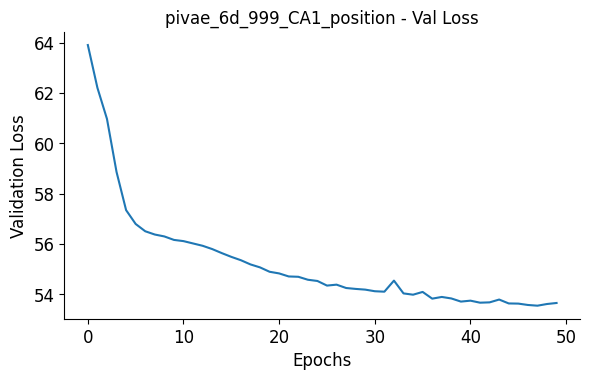

In [22]:
plot_validation_loss(s_n, workflow_name, VERSION, save_plot=False, show_plot=True)

In [23]:
outputs = inference(vae, x_all, u_all, model_chk_path) # post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var

##### TODO: clean/Package this variance compute and sort code

In [24]:
# Calculate variances of all columns of outputs[0]
variances = outputs[0].var(axis=0)

# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]

print(sorted_outputs.var(axis=0))

[2.5978482  1.4194633  0.34313005 0.2091121  0.04117271 0.00499222]


#### Plotting

Latent 1 idx: 3
Latent 2 idx: 5


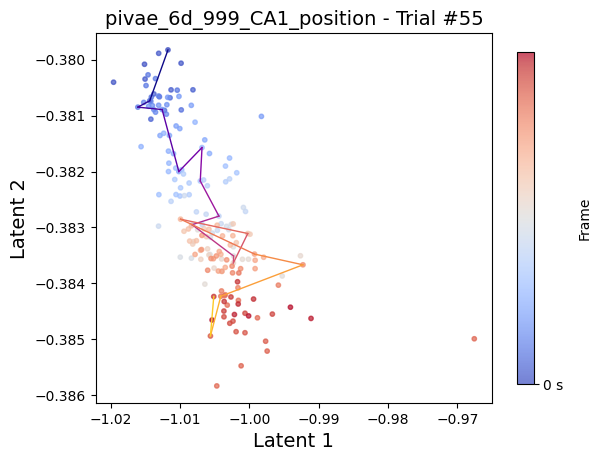

In [25]:
plot_single_latent_trajectory(outputs, sorted_indices, workflow_name, save_plot=False, save_dir=None, show_plot=True)

Latent 1 idx: 3
Latent 2 idx: 5


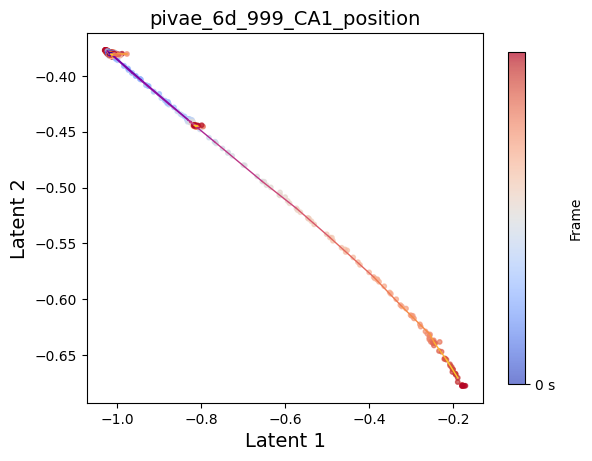

In [26]:
plot_dir = get_plot_dir(workflow_name, version_number=VERSION, plot_type='latent')

plot_multi_latent_trajectory(outputs, sorted_indices, workflow_name, num_stims=15, save_plot=SAVE_PLOTS, save_dir=plot_dir, show_plot=True)

### Pi-VAE - X_h, Total Distance

#### Transform Data

In [27]:
selected_behavior_vars = ['total_distance']

x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, selected_behavior_vars)

#### Load Data

In [28]:
x_train, u_train, x_valid, u_valid, x_test, u_test = load_data(x_all=x_all, u_all=u_all)

In [29]:
model_chk_path, workflow_name = get_model_paths(brain_region=brain_region,
                                    selected_behavior_vars=selected_behavior_vars, 
                                    latent_dim=LATENT_DIM, 
                                    random_seed=RANDOM_SEED, 
                                    model_type=MODEL_TYPES[1]);

print(f"Workflow Name: {workflow_name}")

Workflow Name: pivae_6d_999_CA1_total_distance


In [30]:
# Initialize model
vae = initialize_model(dim_x=x_all[0].shape[-1], 
                       dim_z=LATENT_DIM,
                       dim_u=u_all[0].shape[-1], 
                       gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4, random_seed=RANDOM_SEED)

# Train model
s_n = train_model(vae, x_train, u_train, x_valid, u_valid, model_chk_path)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 134)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 6),                  24964     ['input_7[0][0]',             
                              (None, 6),                             'input_9[0][0]']             
                              (None, 6),                                                          
                              (None, 6),                                                        

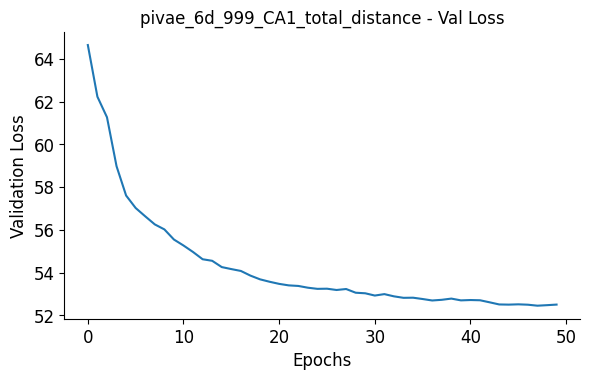

In [31]:
plot_validation_loss(s_n, workflow_name, VERSION, save_plot=SAVE_PLOTS, show_plot=True)

In [32]:
outputs = inference(vae, x_all, u_all, model_chk_path) # post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var

##### TODO: clean/Package this variance compute and sort code

In [33]:
# Calculate variances of all columns of outputs[0]
variances = outputs[0].var(axis=0)

# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]

print(sorted_outputs.var(axis=0))

[2.6640806e+00 1.6297276e+00 8.9146143e-01 8.4700888e-01 7.0656203e-02
 1.6152754e-03]


#### Plotting

Latent 1 idx: 1
Latent 2 idx: 5


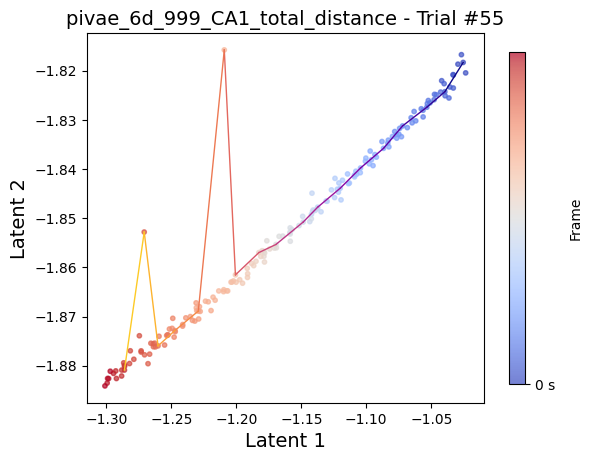

In [34]:
save_plot = False

plot_single_latent_trajectory(outputs, sorted_indices, workflow_name, save_plot=save_plot, save_dir=None, show_plot=True)

Latent 1 idx: 1
Latent 2 idx: 5


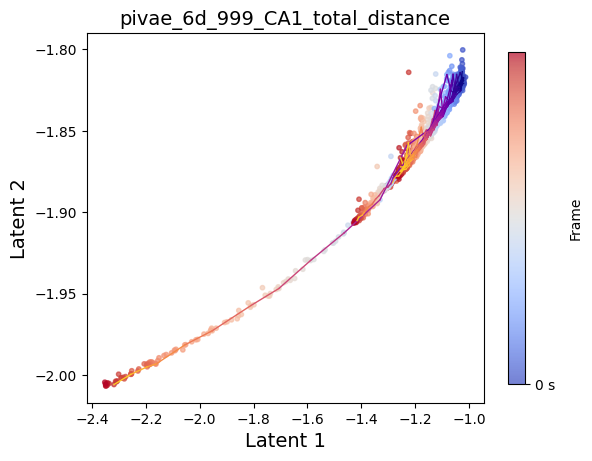

In [35]:
save_plot = False

plot_dir = get_plot_dir(workflow_name, version_number=VERSION, plot_type='latent')

plot_multi_latent_trajectory(outputs, sorted_indices, workflow_name, num_stims=15, save_plot=save_plot, save_dir=plot_dir, show_plot=True)